Для завдання використовувався google colab

In [1]:
%load_ext tensorboard

!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.metrics import AUC 
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from PIL import Image

np.random.seed(42)
tf.random.set_seed(42)

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 32

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


170498071/170498071 [==============================] - 2s 0us/step


## Приклад наших зображень

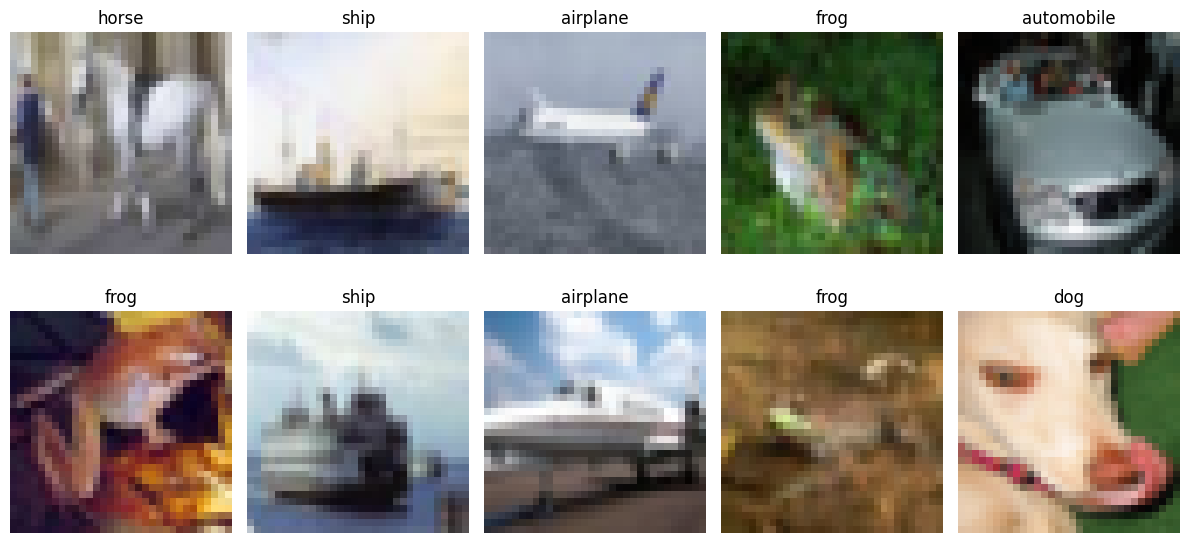

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

random_indices = np.random.choice(X_train.shape[0], size=10, replace=False)

for i, index in enumerate(random_indices):
    image = X_train[index]
    label = y_train[index][0]
    axes[i].imshow(image)
    axes[i].set_title(class_names[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Як ми бачимо ми маємо дуже пікселізовані зображення 

# Підготовка даних

Окрім нормалізації пікселів (ми знаємо, що вони не нормалізовані з документації) і кодування классів до OHE більше ніякої підготовки проводити не будемо для наших даних, також залишимо 3 кольори, оскільки це важливо для наших даних

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255
)

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

train_generator = datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test_ohe, batch_size=batch_size)

# Моделі


In [5]:
input_shape = (32, 32, 3)

inputs = Input(shape=input_shape)

F-1 score ми будемо рахувати через "macro вагу", датасет у нас збалансований, тому це повинно бути гарни рішенням

## Моделі зі стохастичним градієнтним спуском


### Модель прямого розповсюдження

In [6]:
x = Flatten()(inputs)
outputs = Dense(10, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=1.0))(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_sgd')
checkpoint_callback = ModelCheckpoint('./checkpoints/sgd_checkpoint.h5', save_best_only=True, save_weights_only=True)

In [7]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=10)

Epoch 1/10
1563/1563 [==============================] - 16s 6ms/step - loss: 11.9778 - accuracy: 0.1547 - auc: 0.5527 - f1_score: 0.1539 - val_loss: 9.2039 - val_accuracy: 0.1947 - val_auc: 0.5902 - val_f1_score: 0.1937
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 8.3666 - accuracy: 0.2026 - auc: 0.6014 - f1_score: 0.2021 - val_loss: 7.7695 - val_accuracy: 0.2140 - val_auc: 0.6136 - val_f1_score: 0.2130
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 7.2958 - accuracy: 0.2179 - auc: 0.6194 - f1_score: 0.2176 - val_loss: 6.9964 - val_accuracy: 0.2212 - val_auc: 0.6248 - val_f1_score: 0.2209
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 6.6272 - accuracy: 0.2273 - auc: 0.6318 - f1_score: 0.2270 - val_loss: 6.3947 - val_accuracy: 0.2303 - val_auc: 0.6355 - val_f1_score: 0.2278
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 6.1385 - accuracy: 0.2344 - auc: 0.6407 - f1_score

Оскільки через tensorboard не можна вивести одразу декілька вікон, то код закоментований, але tensorboard працює і там були зроблені висновки по усім моделям, для вашої наглядності після кожної моделі виведено графіки самя для цієї моделі

In [8]:
# %tensorboard --logdir=./logs_sgd

Text(0.5, 1.0, 'F1-score')

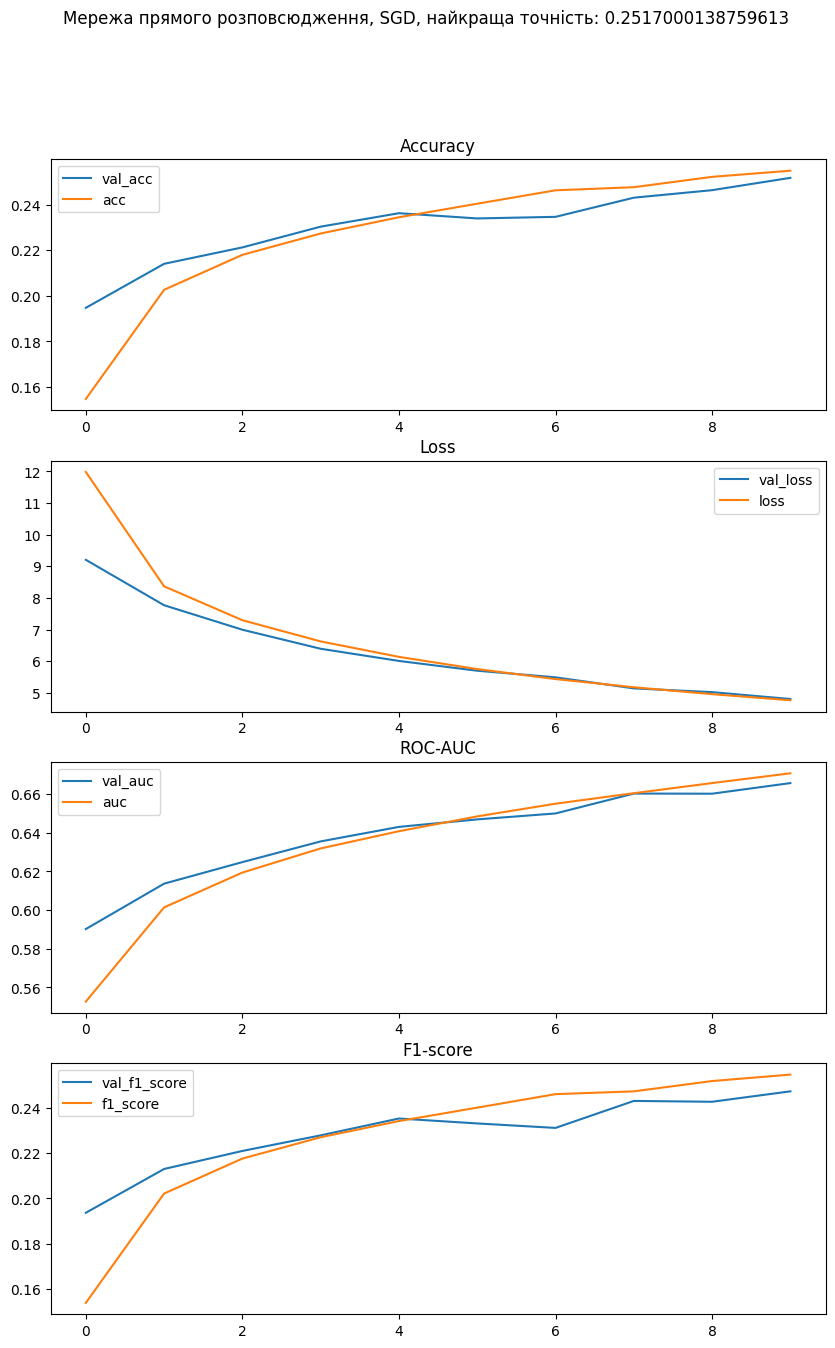

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'Мережа прямого розповсюдження, SGD, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc'], label='val_auc')
ax[2].plot(history.history['auc'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Як ми бачимо модель показала себе погано

### З кількома скритими шарами ReLU, та випадкова ініціалізація

In [11]:
x = Flatten()(inputs)

x = Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=1.0))(x)
x = Dense(64, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=1.0))(x)

outputs = Dense(10, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=1.0))(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_relu_sgd')
checkpoint_callback = ModelCheckpoint('./checkpoints/relu_sgd_checkpoint.h5', save_best_only=True, save_weights_only=True)


In [12]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=10)

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 14.0704 - accuracy: 0.0994 - auc_1: 0.4994 - f1_score: 0.0494 - val_loss: 2.4453 - val_accuracy: 0.1000 - val_auc_1: 0.5000 - val_f1_score: 0.0184
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3398 - accuracy: 0.0983 - auc_1: 0.4976 - f1_score: 0.0828 - val_loss: 2.3961 - val_accuracy: 0.0999 - val_auc_1: 0.4999 - val_f1_score: 0.0182
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3209 - accuracy: 0.0977 - auc_1: 0.4969 - f1_score: 0.0725 - val_loss: 2.3830 - val_accuracy: 0.0998 - val_auc_1: 0.4999 - val_f1_score: 0.0182
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3139 - accuracy: 0.0982 - auc_1: 0.4982 - f1_score: 0.0862 - val_loss: 2.3722 - val_accuracy: 0.0999 - val_auc_1: 0.5001 - val_f1_score: 0.0182
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3092 - accuracy: 0.0991 - auc_1:

In [13]:
# %tensorboard --logdir=./logs_relu_sgd

Text(0.5, 1.0, 'F1-score')

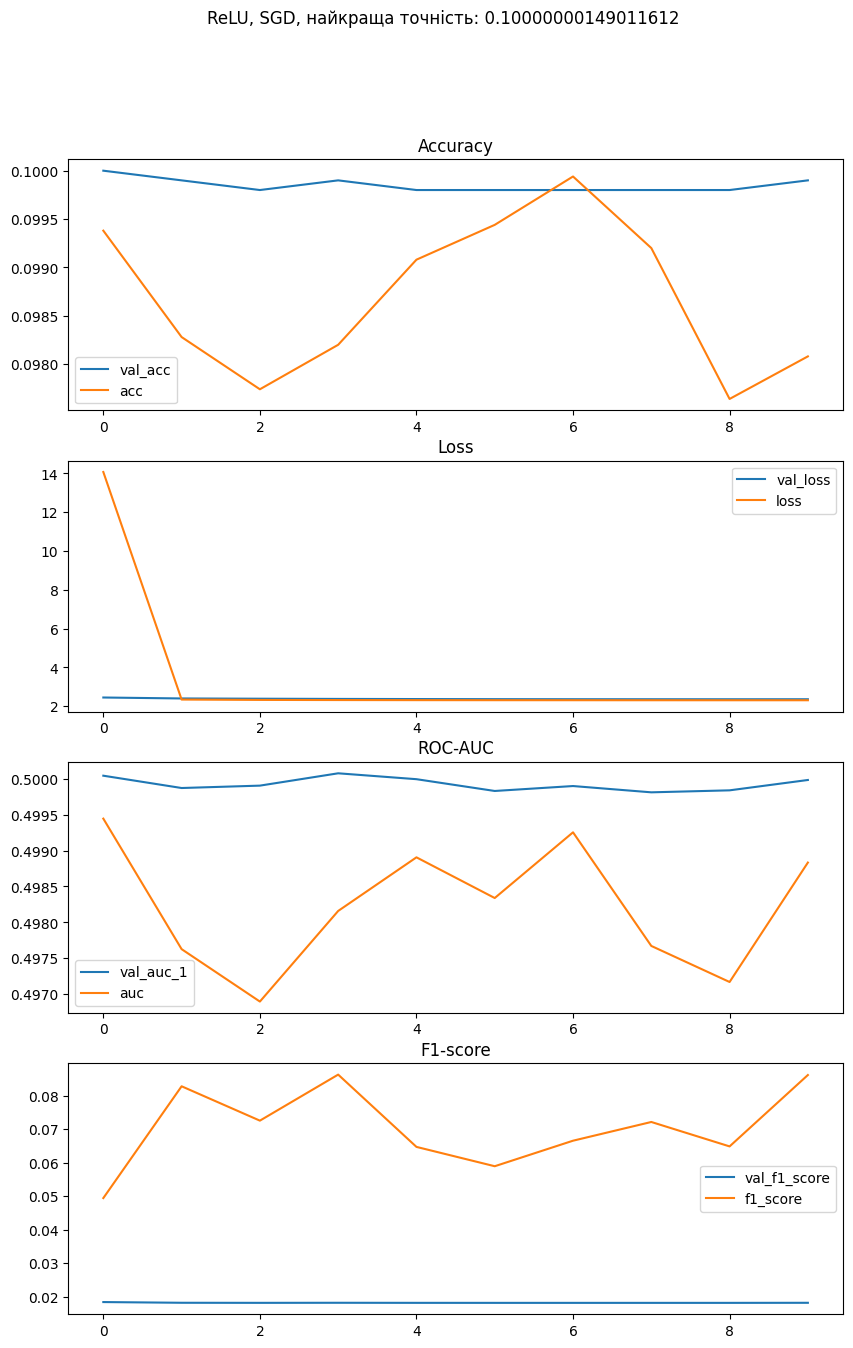

In [17]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ReLU, SGD, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_1'], label='val_auc_1')
ax[2].plot(history.history['auc_1'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Цікаво, що модель зі скритими шарами показала себе гірше ніж без них, вона на рівні простого вгадування, спробуємо задати іншу ініціалізацію

### З кількома скритими шарами ReLU, та ініціалізація Хе

In [18]:
x = Flatten()(inputs)

x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_relu_he_sgd')
checkpoint_callback = ModelCheckpoint('./checkpoints/relu_he_sgd_checkpoint.h5', save_best_only=True, save_weights_only=True)


In [19]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8777 - accuracy: 0.3241 - auc_2: 0.7786 - f1_score: 0.3191 - val_loss: 1.7194 - val_accuracy: 0.3946 - val_auc_2: 0.8222 - val_f1_score: 0.3903
Epoch 2/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7094 - accuracy: 0.3920 - auc_2: 0.8246 - f1_score: 0.3870 - val_loss: 1.6589 - val_accuracy: 0.4040 - val_auc_2: 0.8374 - val_f1_score: 0.3962
Epoch 3/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6318 - accuracy: 0.4202 - auc_2: 0.8421 - f1_score: 0.4151 - val_loss: 1.6205 - val_accuracy: 0.4217 - val_auc_2: 0.8439 - val_f1_score: 0.3946
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5749 - accuracy: 0.4414 - auc_2: 0.8541 - f1_score: 0.4364 - val_loss: 1.5763 - val_accuracy: 0.4350 - val_auc_2: 0.8545 - val_f1_score: 0.4255
Epoch 5/15
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5359 - accuracy: 0.4531 - auc_2: 

In [20]:
# %tensorboard --logdir=./logs_relu_he_sgd

Text(0.5, 1.0, 'F1-score')

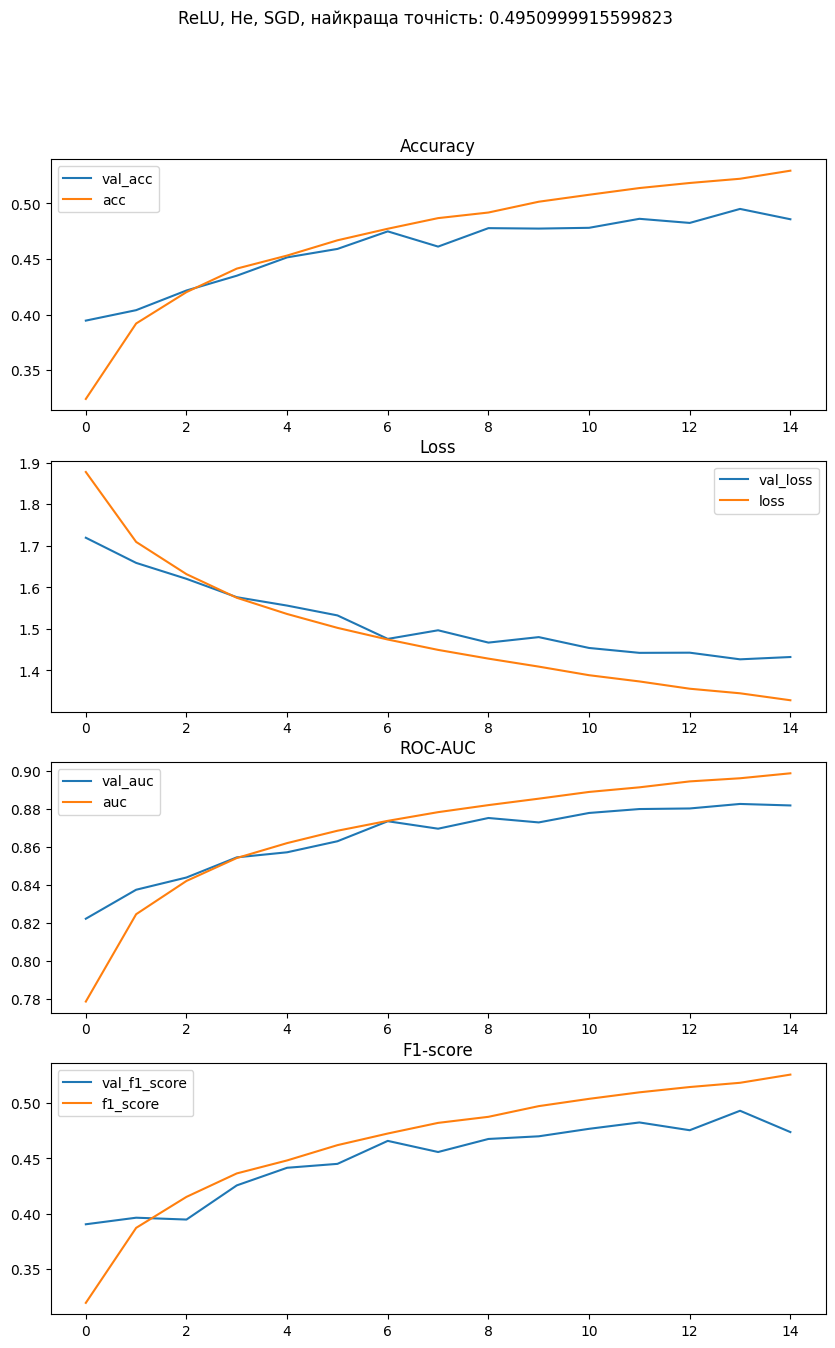

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ReLU, He, SGD, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_2'], label='val_auc')
ax[2].plot(history.history['auc_2'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Як ми бачимо інша ініціалізація сильно змінила результат і ми отримали набагато кращий результат, спробуємо іншу функцію активації

Також варто зазначити наше високе значення ROC-AUC, це означає, що наша модель дуже впевнена у правильних класифікаціях, та і точність 50% для 10 классів дуже непогано, щодо F-1 (0.5), то тут модель показує себе також непогано як для 10 классів

Швидкість навчання також не сильно змінилась

### З кількома скритими шарами Leaky ReLU, та ініціалізація Хе

Оскільки активаційні функції, Leaky ReLU та ELU - несиметричні, то ми будемо використовувати ініціалізацію Хе для усіх

In [24]:
x = Flatten()(inputs)

x = Dense(128, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_normal')(x)
x = Dense(64, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_normal')(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_leaky_relu_sgd')
checkpoint_callback = ModelCheckpoint('./checkpoints/relu_leaky_sgd_checkpoint.h5', save_best_only=True, save_weights_only=True)

In [25]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 9s 5ms/step - loss: 1.8945 - accuracy: 0.3202 - auc_3: 0.7733 - f1_score: 0.3156 - val_loss: 1.7425 - val_accuracy: 0.3761 - val_auc_3: 0.8164 - val_f1_score: 0.3675
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7164 - accuracy: 0.3917 - auc_3: 0.8231 - f1_score: 0.3868 - val_loss: 1.6902 - val_accuracy: 0.3989 - val_auc_3: 0.8287 - val_f1_score: 0.3837
Epoch 3/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6392 - accuracy: 0.4204 - auc_3: 0.8407 - f1_score: 0.4153 - val_loss: 1.6363 - val_accuracy: 0.4276 - val_auc_3: 0.8394 - val_f1_score: 0.4147
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5865 - accuracy: 0.4374 - auc_3: 0.8521 - f1_score: 0.4322 - val_loss: 1.6119 - val_accuracy: 0.4264 - val_auc_3: 0.8466 - val_f1_score: 0.4171
Epoch 5/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5484 - accuracy: 0.4520 - auc_3: 0

In [26]:
# %tensorboard --logdir=./logs_leaky_relu_sgd

Text(0.5, 1.0, 'F1-score')

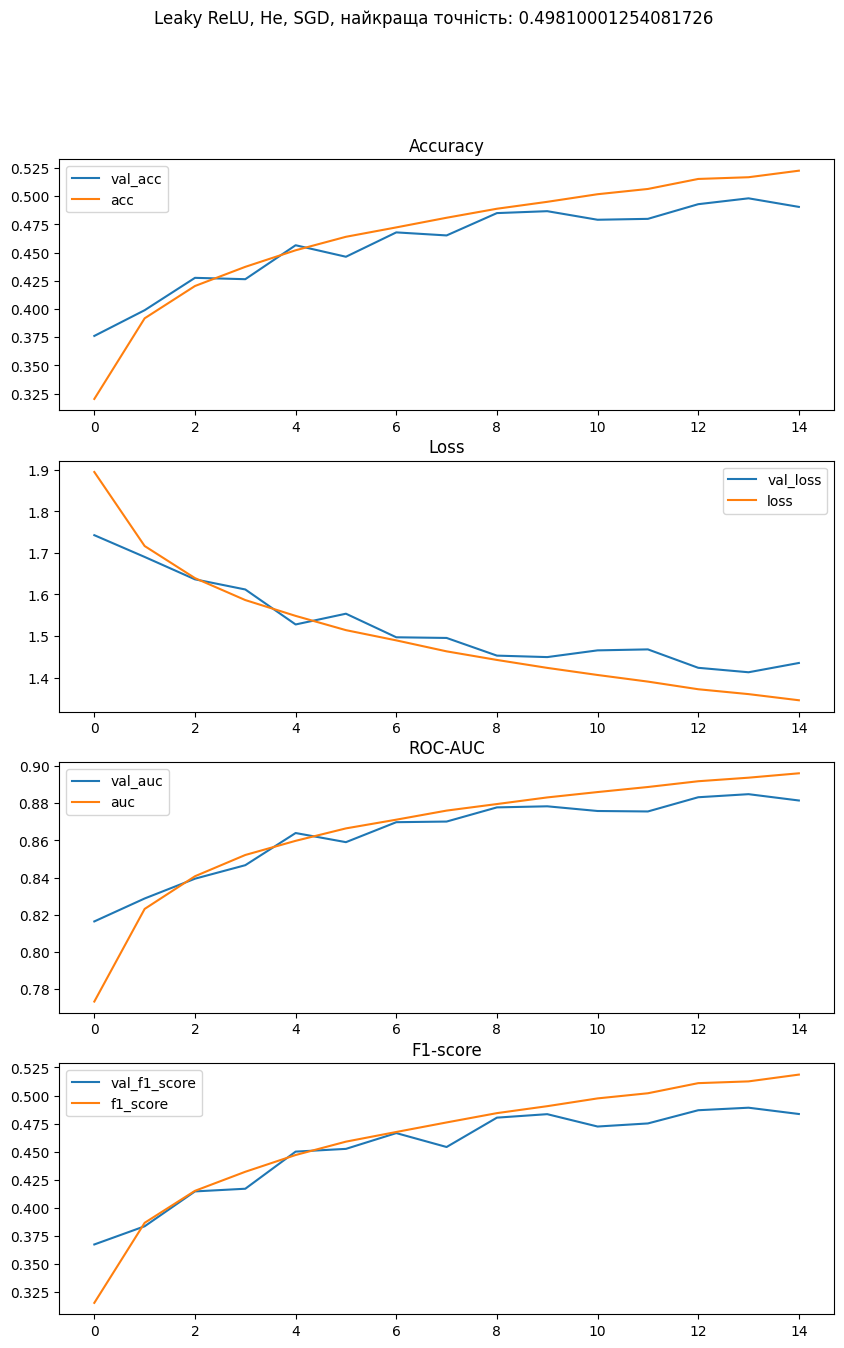

In [28]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'Leaky ReLU, He, SGD, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_3'], label='val_auc')
ax[2].plot(history.history['auc_3'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Інша функція активації не вплинула на результат, ситуація з метриками схожа на попередню

### З кількома скритими шарами ELU, та ініціалізація Хе

In [29]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_sgd')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_sgd_checkpoint.h5', save_best_only=True, save_weights_only=True)

In [30]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 9s 5ms/step - loss: 1.8810 - accuracy: 0.3288 - auc_4: 0.7776 - f1_score: 0.3238 - val_loss: 1.7530 - val_accuracy: 0.3792 - val_auc_4: 0.8139 - val_f1_score: 0.3647
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7057 - accuracy: 0.3955 - auc_4: 0.8257 - f1_score: 0.3913 - val_loss: 1.6267 - val_accuracy: 0.4214 - val_auc_4: 0.8441 - val_f1_score: 0.4147
Epoch 3/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6279 - accuracy: 0.4236 - auc_4: 0.8434 - f1_score: 0.4194 - val_loss: 1.5854 - val_accuracy: 0.4440 - val_auc_4: 0.8525 - val_f1_score: 0.4438
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5773 - accuracy: 0.4405 - auc_4: 0.8539 - f1_score: 0.4362 - val_loss: 1.5351 - val_accuracy: 0.4622 - val_auc_4: 0.8625 - val_f1_score: 0.4566
Epoch 5/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5401 - accuracy: 0.4570 - auc_4: 0

In [31]:
# %tensorboard --logdir=./logs_elu_sgd

Text(0.5, 1.0, 'F1-score')

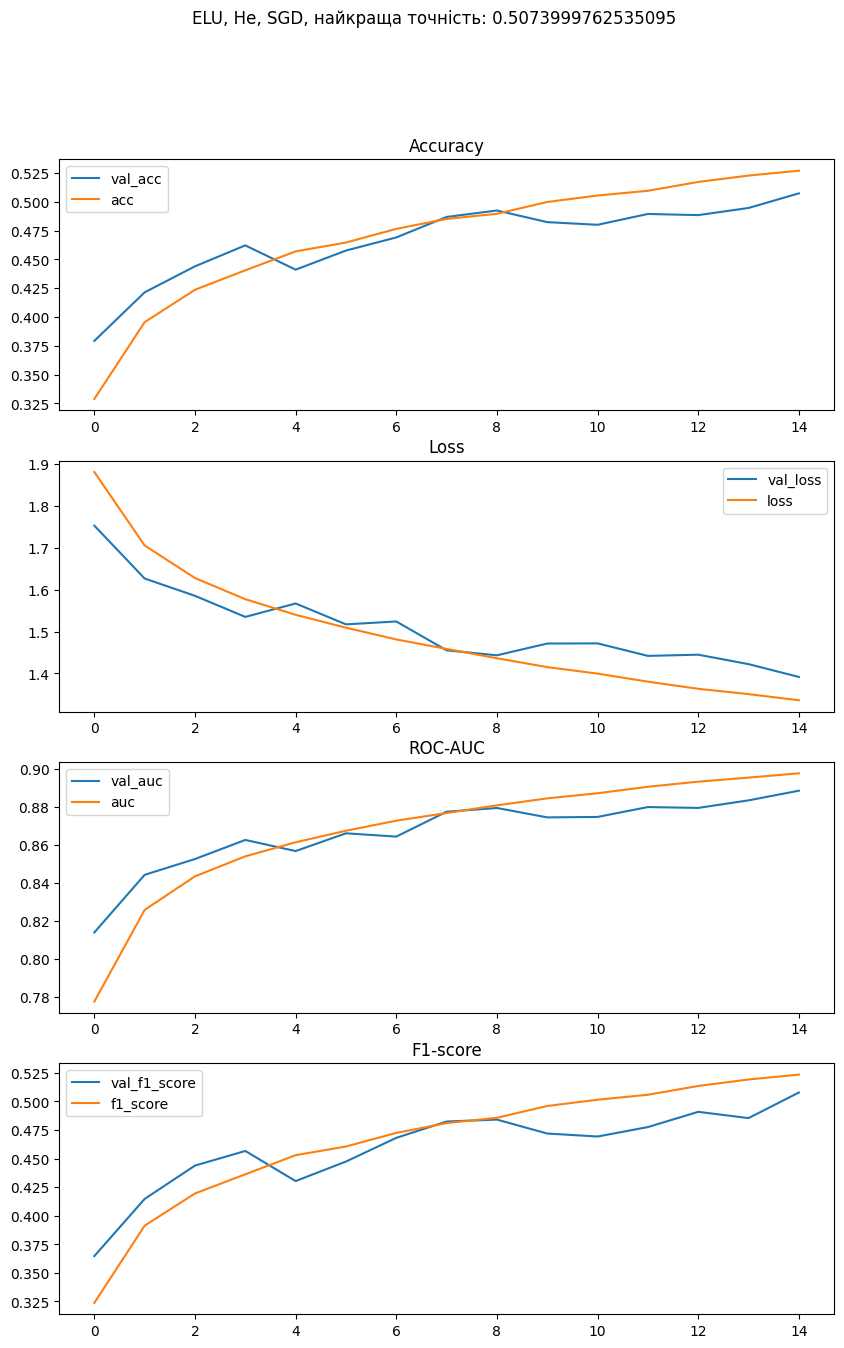

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, He, SGD, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_4'], label='val_auc')
ax[2].plot(history.history['auc_4'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Інша функція активації не вплинула на результат, ситуація з метриками схожа на попередню

## Використання алгоритму Adam
Навчимо найкращу модель з попередніх тестів - насправді будь яка з ініціалізацією ваг Хе, але найбільша точність на тестовому датасеті була у ELU

### ELU, Adam

In [34]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_adam')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_adam_checkpoint.h5', save_best_only=True, save_weights_only=True)

In [35]:
%%time
# Train the model
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 11s 6ms/step - loss: 1.8791 - accuracy: 0.3279 - auc_5: 0.7799 - f1_score: 0.3244 - val_loss: 1.7493 - val_accuracy: 0.3718 - val_auc_5: 0.8129 - val_f1_score: 0.3528
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6840 - accuracy: 0.3974 - auc_5: 0.8304 - f1_score: 0.3934 - val_loss: 1.6585 - val_accuracy: 0.4038 - val_auc_5: 0.8357 - val_f1_score: 0.3790
Epoch 3/15
1563/1563 [==============================] - 9s 5ms/step - loss: 1.6061 - accuracy: 0.4249 - auc_5: 0.8479 - f1_score: 0.4209 - val_loss: 1.5843 - val_accuracy: 0.4354 - val_auc_5: 0.8524 - val_f1_score: 0.4178
Epoch 4/15
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5490 - accuracy: 0.4446 - auc_5: 0.8595 - f1_score: 0.4402 - val_loss: 1.5131 - val_accuracy: 0.4584 - val_auc_5: 0.8662 - val_f1_score: 0.4385
Epoch 5/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5107 - accuracy: 0.4580 - auc_5: 

In [36]:
# %tensorboard --logdir=./logs_elu_adam

Text(0.5, 1.0, 'F1-score')

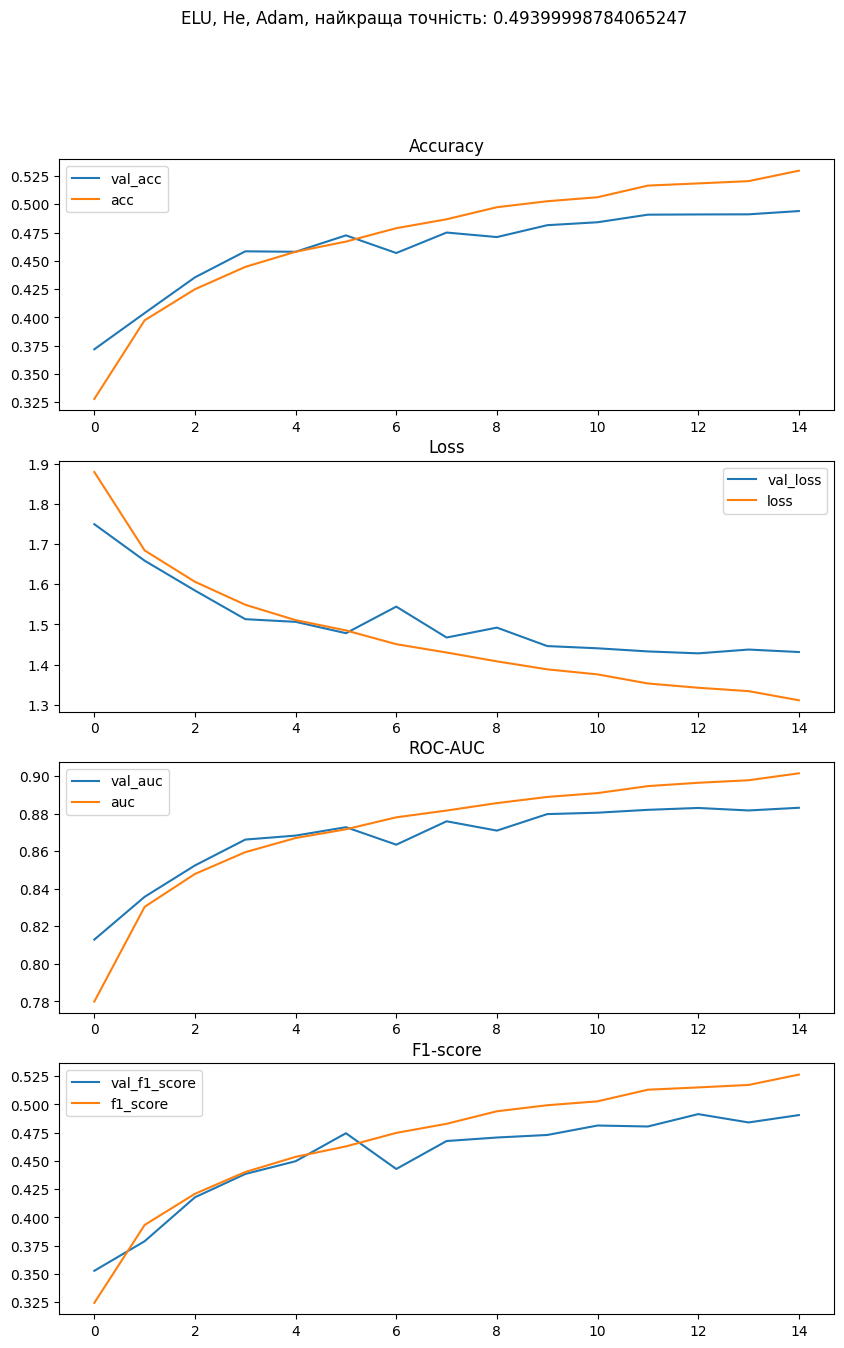

In [38]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, He, Adam, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_5'], label='val_auc')
ax[2].plot(history.history['auc_5'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Модель показала себе схоже, швидкість навчання не змінилася

In [39]:
%%timeit
model.predict(X_test)

313/313 [==============================] - 0s 1ms/step
685 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ELU з нормалізацією за міні-батчами

In [40]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_batchreg')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_batchreg.h5', save_best_only=True, save_weights_only=True)

In [41]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 12s 7ms/step - loss: 1.7363 - accuracy: 0.3856 - auc_6: 0.8182 - f1_score: 0.3817 - val_loss: 1.7498 - val_accuracy: 0.4017 - val_auc_6: 0.8178 - val_f1_score: 0.3652
Epoch 2/15
1563/1563 [==============================] - 10s 7ms/step - loss: 1.5841 - accuracy: 0.4405 - auc_6: 0.8523 - f1_score: 0.4362 - val_loss: 1.7043 - val_accuracy: 0.3917 - val_auc_6: 0.8303 - val_f1_score: 0.3833
Epoch 3/15
1563/1563 [==============================] - 10s 7ms/step - loss: 1.5261 - accuracy: 0.4577 - auc_6: 0.8639 - f1_score: 0.4535 - val_loss: 1.5528 - val_accuracy: 0.4540 - val_auc_6: 0.8596 - val_f1_score: 0.4395
Epoch 4/15
1563/1563 [==============================] - 10s 7ms/step - loss: 1.4810 - accuracy: 0.4763 - auc_6: 0.8726 - f1_score: 0.4725 - val_loss: 1.6567 - val_accuracy: 0.4278 - val_auc_6: 0.8404 - val_f1_score: 0.4275
Epoch 5/15
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4540 - accuracy: 0.4859 - auc

In [42]:
# %tensorboard --logdir=./logs_elu_batchreg

Text(0.5, 1.0, 'F1-score')

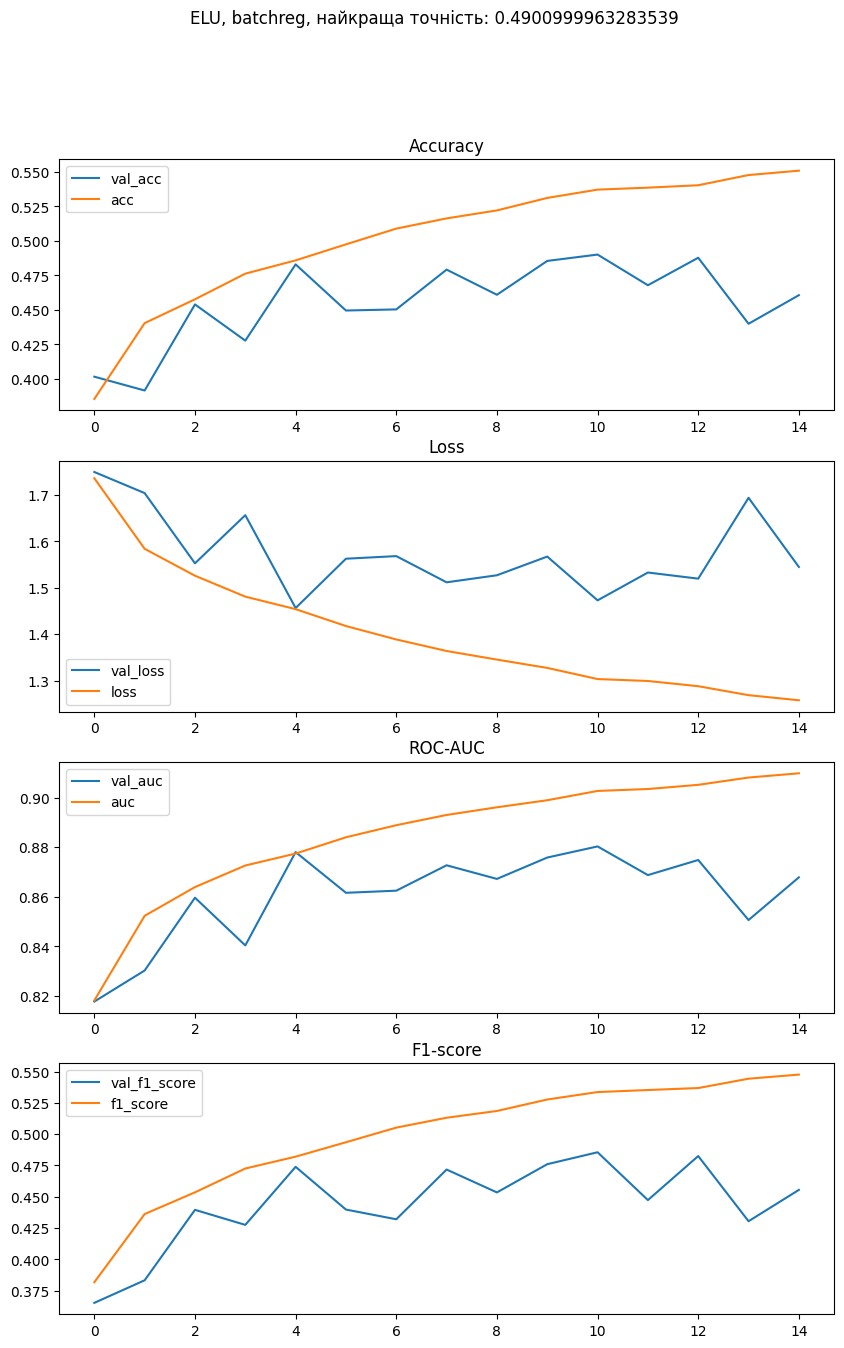

In [45]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, batchreg, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_6'], label='val_auc')
ax[2].plot(history.history['auc_6'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Як ми бачимо модель помітно довше навчається, а значення метрик на валідаційному наборі помітно гірше і більше скаче, що дуже цікаво адже, регуляризація повинна працювати інакше

In [46]:
%%timeit
model.predict(X_test)

313/313 [==============================] - 0s 1ms/step
1.12 s ± 337 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Час надання прогнозу мережею також збільшився 

#### Оберемо більше значення швидкості навчання

In [47]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.05),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_batchreg_highlr')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_batchreg_highlr.h5', save_best_only=True, save_weights_only=True)

In [48]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 16s 8ms/step - loss: 1.9250 - accuracy: 0.3019 - auc_7: 0.7688 - f1_score: 0.2977 - val_loss: 2.0833 - val_accuracy: 0.3120 - val_auc_7: 0.7739 - val_f1_score: 0.2721
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8094 - accuracy: 0.3489 - auc_7: 0.8017 - f1_score: 0.3441 - val_loss: 3.2104 - val_accuracy: 0.2759 - val_auc_7: 0.7601 - val_f1_score: 0.2511
Epoch 3/15
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7689 - accuracy: 0.3679 - auc_7: 0.8125 - f1_score: 0.3630 - val_loss: 3.5292 - val_accuracy: 0.3729 - val_auc_7: 0.8195 - val_f1_score: 0.3603
Epoch 4/15
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7328 - accuracy: 0.3836 - auc_7: 0.8206 - f1_score: 0.3785 - val_loss: 10.9493 - val_accuracy: 0.3532 - val_auc_7: 0.8110 - val_f1_score: 0.3250
Epoch 5/15
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7122 - accuracy: 0.3898 - au

In [49]:
# %tensorboard --logdir=./logs_elu_batchreg_highlr

Text(0.5, 1.0, 'F1-score')

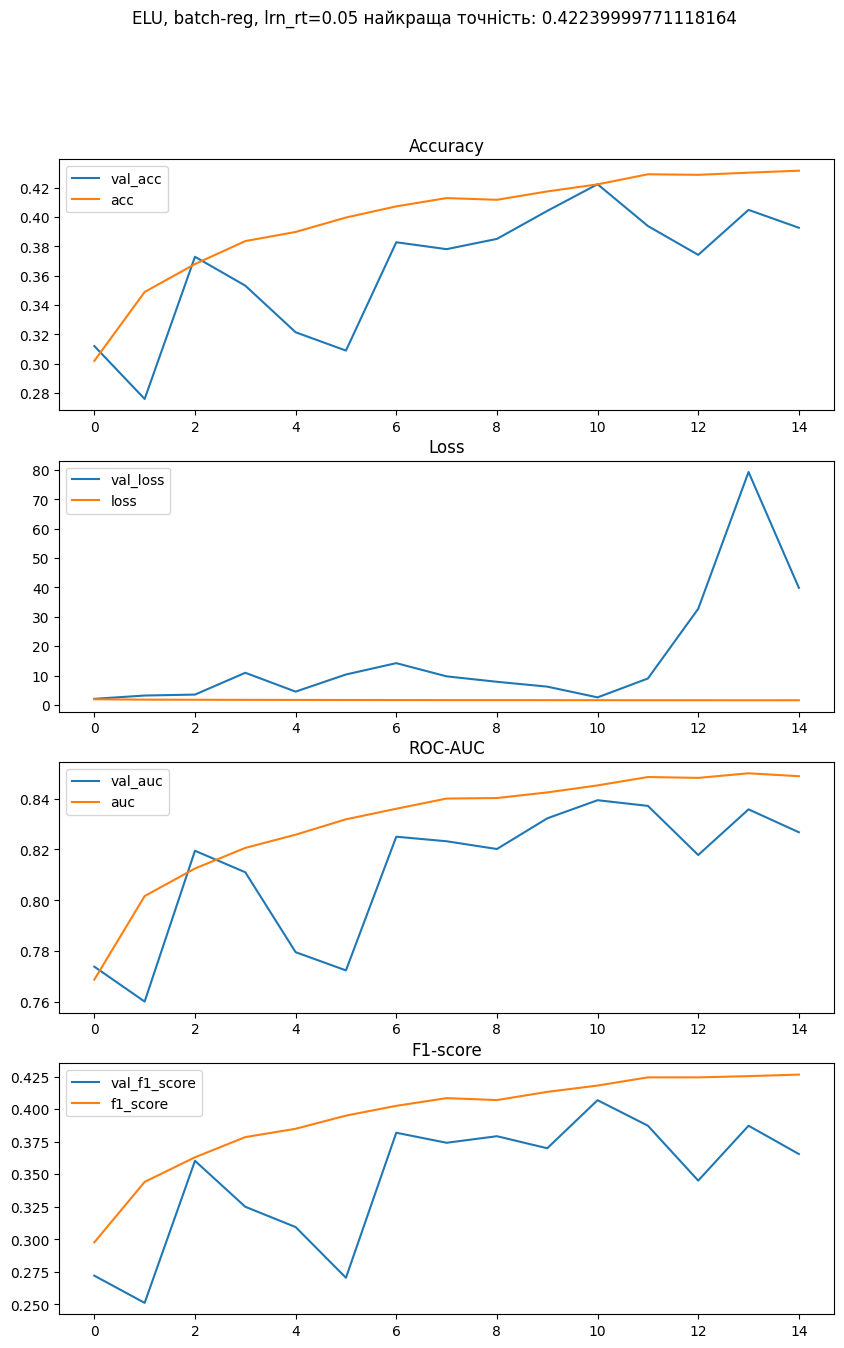

In [52]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, batch-reg, lrn_rt=0.05 найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_7'], label='val_auc')
ax[2].plot(history.history['auc_7'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

In [53]:
%%timeit
model.predict(X_test)

313/313 [==============================] - 1s 2ms/step
760 ms ± 27.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Я пробував інші значення швидкості навчання, з ними модель навчається менш стабільно і дає значення метрик гірші

### ELU з дропаут шарами
Оскільки наша модель не перенавчається, то за значення p я оберу 0.1, адже чим більше наша модель перенавчається, то більше нам потрібне значення p

In [54]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.1)(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.05),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_dropout')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_dropout.h5', save_best_only=True, save_weights_only=True)

In [55]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback],
                    epochs=15)

Epoch 1/15
1563/1563 [==============================] - 10s 5ms/step - loss: 3.8803 - accuracy: 0.0967 - auc_8: 0.4975 - f1_score: 0.0964 - val_loss: 2.4822 - val_accuracy: 0.1000 - val_auc_8: 0.5000 - val_f1_score: 0.0182
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 2.4809 - accuracy: 0.1024 - auc_8: 0.5012 - f1_score: 0.1022 - val_loss: 2.4571 - val_accuracy: 0.1000 - val_auc_8: 0.5000 - val_f1_score: 0.0182
Epoch 3/15
1563/1563 [==============================] - 8s 5ms/step - loss: 2.5363 - accuracy: 0.1021 - auc_8: 0.5005 - f1_score: 0.1020 - val_loss: 2.6231 - val_accuracy: 0.1000 - val_auc_8: 0.5000 - val_f1_score: 0.0182
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 2.5866 - accuracy: 0.1013 - auc_8: 0.5005 - f1_score: 0.1012 - val_loss: 2.4302 - val_accuracy: 0.1000 - val_auc_8: 0.5000 - val_f1_score: 0.0182
Epoch 5/15
1563/1563 [==============================] - 8s 5ms/step - loss: 2.6167 - accuracy: 0.0984 - auc_8: 

In [56]:
# %tensorboard --logdir=./logs_elu_dropout

Text(0.5, 1.0, 'F1-score')

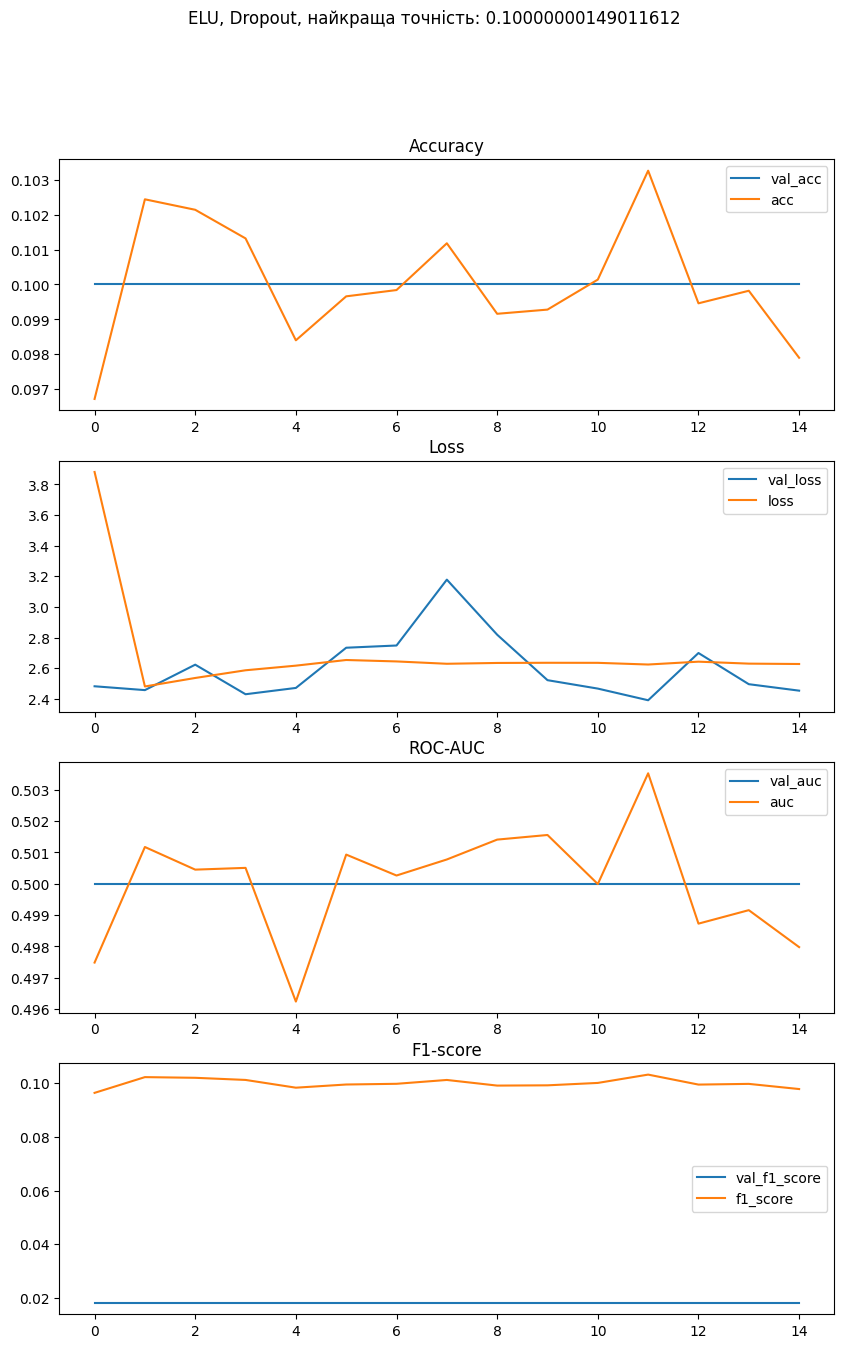

In [57]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, Dropout, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_8'], label='val_auc')
ax[2].plot(history.history['auc_8'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Модель з дропаутами на рівні із моделлю зі скритими шарами, де ваги ініціалізаютсья випадково, тобто найгірша, на рівні з простим вгадуванням  

### Модель з ELU, ранньою зупинкою та регуляризацією l2
Для цієї моделі зробимо більшу кількість нейронів, та більшу кількість епох, адже ми використовуємо також ранню зупинку

In [58]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_earlystop_reg')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_earlystop_reg.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=3, verbose=1)

In [59]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback],
                    epochs=100)

Epoch 1/100
1563/1563 [==============================] - 10s 5ms/step - loss: 2.6492 - accuracy: 0.3013 - auc_9: 0.7594 - f1_score: 0.2941 - val_loss: 2.0281 - val_accuracy: 0.3312 - val_auc_9: 0.7967 - val_f1_score: 0.2874
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.0226 - accuracy: 0.3272 - auc_9: 0.7880 - f1_score: 0.3191 - val_loss: 1.9183 - val_accuracy: 0.3840 - val_auc_9: 0.8153 - val_f1_score: 0.3702
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9816 - accuracy: 0.3359 - auc_9: 0.7940 - f1_score: 0.3279 - val_loss: 1.9392 - val_accuracy: 0.3535 - val_auc_9: 0.8045 - val_f1_score: 0.3351
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9597 - accuracy: 0.3433 - auc_9: 0.7990 - f1_score: 0.3359 - val_loss: 1.9175 - val_accuracy: 0.3639 - val_auc_9: 0.8112 - val_f1_score: 0.3441
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.9447 - accuracy: 0.3484 - au

In [60]:
# %tensorboard --logdir=./logs_elu_earlystop_reg

Text(0.5, 1.0, 'F1-score')

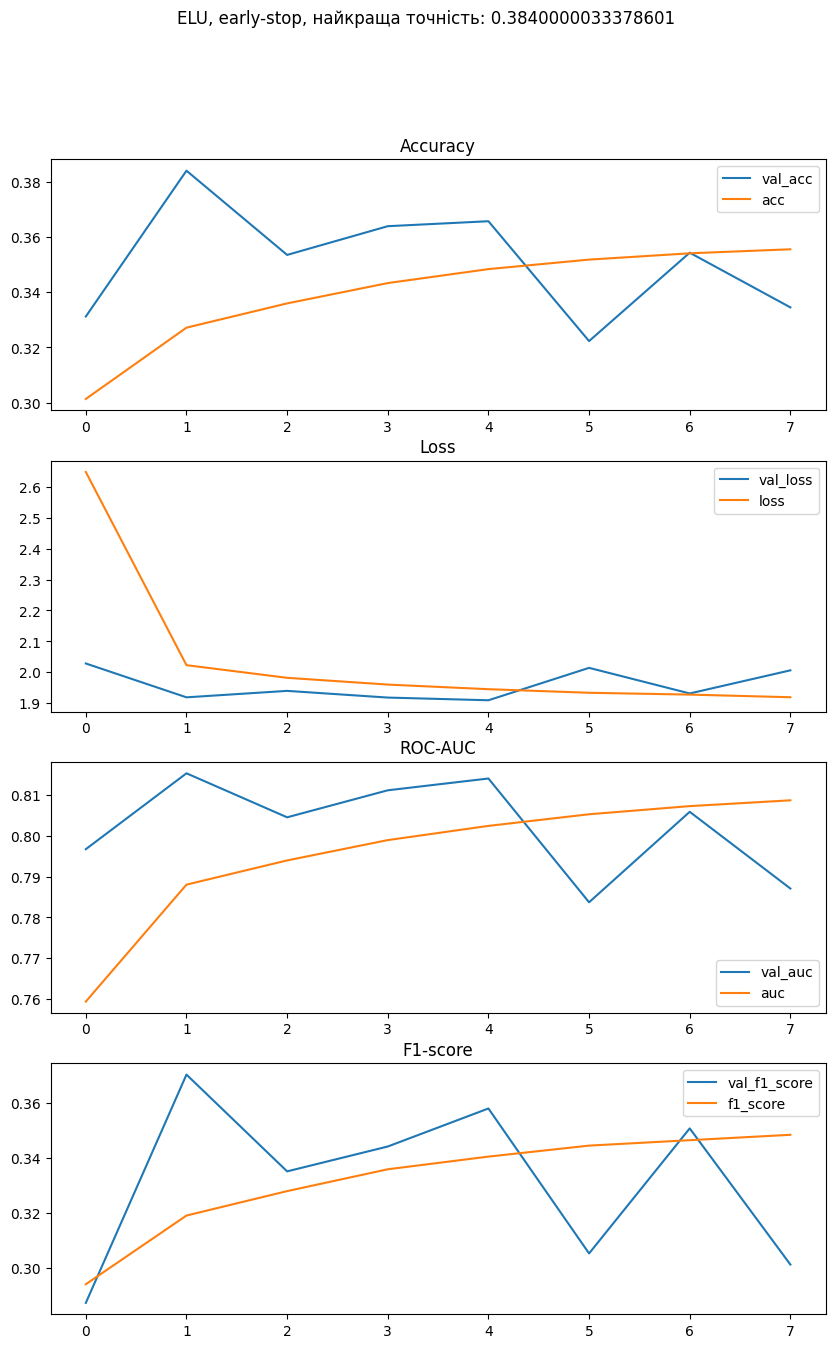

In [62]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, early-stop, найкраща точність: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_9'], label='val_auc')
ax[2].plot(history.history['auc_9'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Як ми бачимо навіть така невелика кількість регуляризації не дає нашій модель хоч якось пристосуватися до даних порівняно з моделлю без регуляризації, я не додавав MaxNorm, тому що так наша модель отримувала точність 10% і не була кращою за звичайне вгадування

Також навчання припинилося через 7 епох

# Тест найкращої моделі на новій фотографії

Як найкраща модель у нас це зі скритими шарами, активацією - ELU, ініціалізацією Хе, та без регуляризації, також додами більше епох та ранню зупинку

## Навчання моделі

In [63]:
x = Flatten()(inputs)

x = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
x = Dense(64, activation='elu', kernel_initializer='he_normal')(x)

outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(), F1Score(num_classes=10, average='macro')])

tensorboard_callback = TensorBoard(log_dir='./logs_elu_adam')
checkpoint_callback = ModelCheckpoint('./checkpoints/elu_adam_checkpoint.h5', save_best_only=True, save_weights_only=True)
early_stopping_callback = EarlyStopping(patience=3, verbose=1)

In [64]:
%%time
history = model.fit(train_generator,
                    validation_data=test_generator,
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback],
                    epochs=100)

Epoch 1/100
1563/1563 [==============================] - 10s 5ms/step - loss: 1.8938 - accuracy: 0.3216 - auc_10: 0.7775 - f1_score: 0.3165 - val_loss: 1.7536 - val_accuracy: 0.3659 - val_auc_10: 0.8156 - val_f1_score: 0.3559
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6801 - accuracy: 0.3972 - auc_10: 0.8318 - f1_score: 0.3920 - val_loss: 1.6220 - val_accuracy: 0.4270 - val_auc_10: 0.8439 - val_f1_score: 0.4144
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6038 - accuracy: 0.4270 - auc_10: 0.8485 - f1_score: 0.4217 - val_loss: 1.6659 - val_accuracy: 0.4068 - val_auc_10: 0.8350 - val_f1_score: 0.4011
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5439 - accuracy: 0.4466 - auc_10: 0.8607 - f1_score: 0.4414 - val_loss: 1.5250 - val_accuracy: 0.4532 - val_auc_10: 0.8646 - val_f1_score: 0.4398
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5106 - accuracy: 0.4

In [65]:
# %tensorboard --logdir=./logs_elu_adam

Text(0.5, 1.0, 'F1-score')

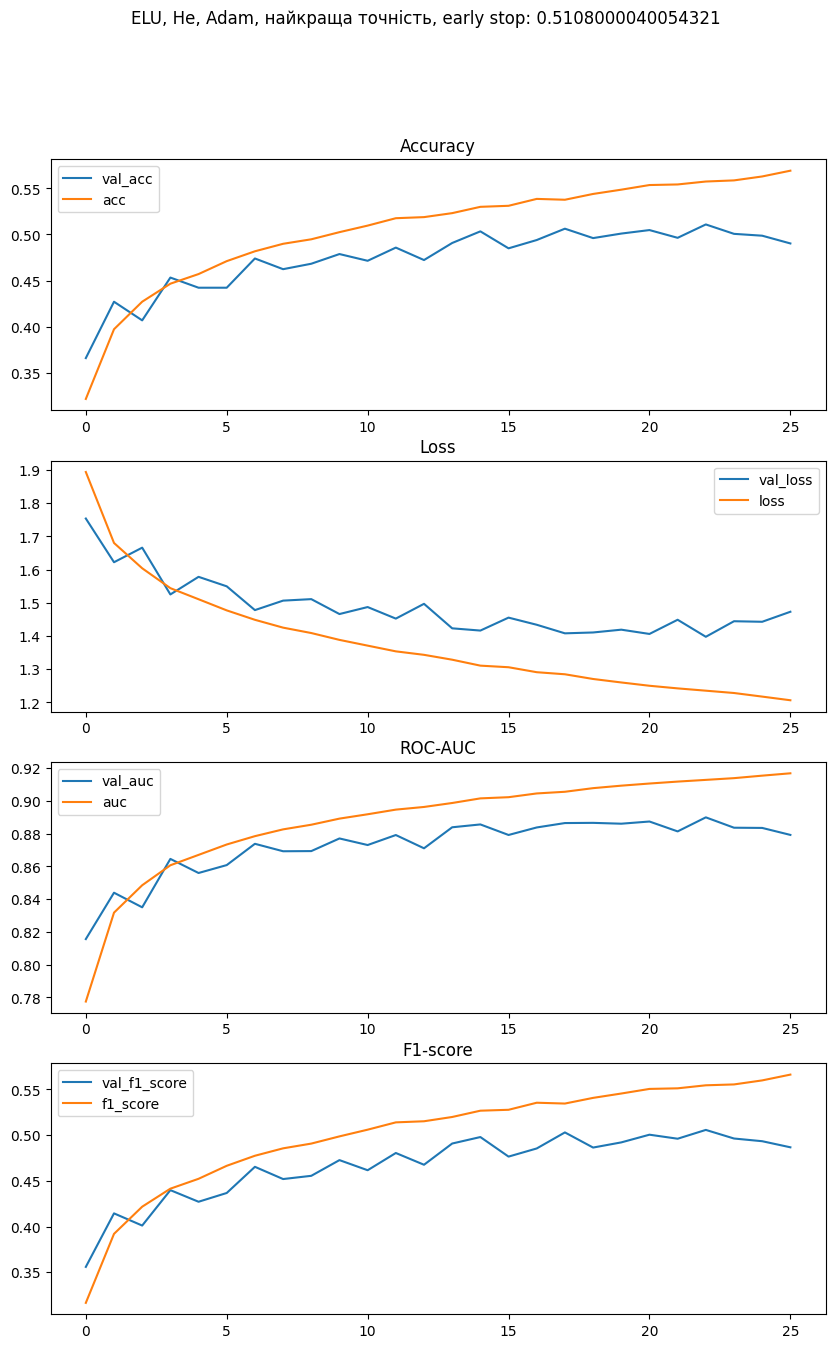

In [66]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))
fig.suptitle(f'ELU, He, Adam, найкраща точність, early stop: {max(history.history["val_accuracy"])}')

ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].plot(history.history['accuracy'], label='acc')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].plot(history.history['loss'], label='loss')
ax[1].legend()
ax[1].set_title('Loss')

ax[2].plot(history.history['val_auc_10'], label='val_auc')
ax[2].plot(history.history['auc_10'], label='auc')
ax[2].legend()
ax[2].set_title('ROC-AUC')

ax[3].plot(history.history['val_f1_score'], label='val_f1_score')
ax[3].plot(history.history['f1_score'], label='f1_score')
ax[3].legend()
ax[3].set_title('F1-score')

Як ми бачимо рання зупинка спрацювала на 25 епосі, мабуть далі модель вже починає перенавчання і 50% точності це максимум який ми можемо отримати завдяки цій моделі, але загалом дуже непогана модель

## Фотографії:

1/1 [==============================] - 0s 60ms/step


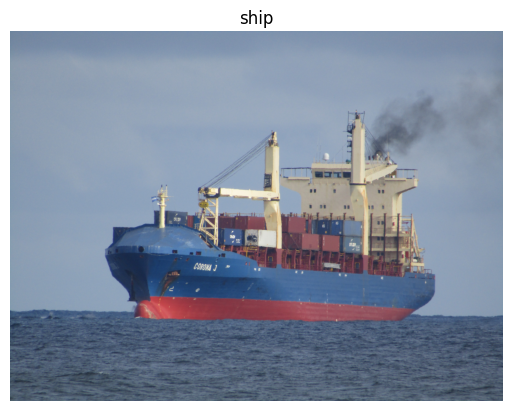

In [69]:
img_path = '/content/Cargo_Ship_Puerto_Cortes.jpg'  
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))  
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  #

prediction = model.predict(x)
predicted_label = np.argmax(prediction)

img = tf.keras.preprocessing.image.load_img(img_path)
plt.imshow(img)
plt.axis('off')

plt.title(class_names[predicted_label])
plt.show()

Як ми бачимо наша модель правильно класифікувала корабель

1/1 [==============================] - 0s 20ms/step


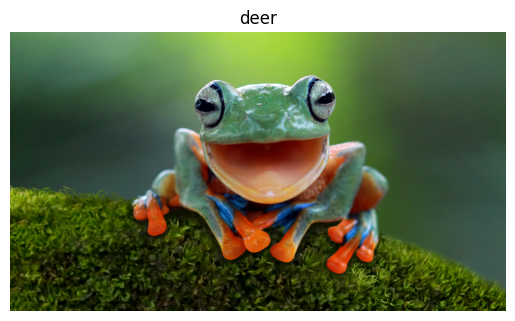

In [70]:
img_path = '/content/frog.jpg'  
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))  
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  #

prediction = model.predict(x)
predicted_label = np.argmax(prediction)

img = tf.keras.preprocessing.image.load_img(img_path)
plt.imshow(img)
plt.axis('off')

plt.title(class_names[predicted_label])
plt.show()

Але не справилася з жабою

# Висновки:


Ми побудували і навчили велику кількіть нейроних мереж, виявилося, що правильна ініціалізація ваг дуже сильно впливає на результат, регуляризація на наших даних робила тільки гірше, мабуть однією з причин є те, що ми використовували MLP для класифікування зображень, але загалом ми впевнилися у тому, що багатошаровий персептрон не справляється з задачею класифікування зображень